# Use Transformer Encoder to generate the distribution
2. Deep Learning Models: VAE, Diffusion Model, Self-attention, and Transformer

### Import libraries

In [1]:
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm
from torch import Tensor
import math
import matplotlib.pyplot as plt

### Define the model architecture using a self-attention modules

In [2]:
# Define the model
class SelfAttentionGenerator(nn.Module):
    def __init__(self, input_dim=5, output_dim=5, num_heads=8, hidden_dim=512, num_layers=6, batch_size=64):
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, batch_size, hidden_dim))
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.attention_layers = nn.ModuleList([nn.MultiheadAttention(hidden_dim, num_heads) for _ in range(num_layers)])
        self.feedforward_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(0.5)
        ) for _ in range(num_layers)])
        self.out_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = x.transpose(0, 1)  # (seq_len, batch_size, hidden_dim)
        x += self.pos_embedding
        x = self.dropout(x)
        x = self.layer_norm(x)
        for attn_layer, ff_layer in zip(self.attention_layers, self.feedforward_layers):
            x, _ = attn_layer(x, x, x)
            x = self.layer_norm(x)
            x = ff_layer(x)
            x = self.layer_norm(x)
        x = self.out_layer(x)
        return x.transpose(0, 1).squeeze(1)  # (batch_size, seq_len, output_dim) -> (batch_size, output_dim)

### Define dataset and dataloader
- I use Dataset, Dataloader from torch.utils.data and build customize ColoredPiDataset, and normalize data points to [0, 1] or [-1, 1]:

In [3]:
# Define dataset and dataloader
class ColoredPiDataset(Dataset):
    def __init__(self, image_path, xs_path, ys_path):
        self.xs = np.load(xs_path)
        self.ys = np.load(ys_path)
        self.image_array = np.array(Image.open(image_path))
        self.rgb_values = self.image_array[self.xs, self.ys]
        
        # Normalize xy values to be between 0 and 1
        self.xs, self.ys = self.xs / 299.0, self.ys / 299.0

        # Normalize rgb values to be between 0 and 1
        self.rgb_values = self.rgb_values / 255.0
        
        # # Normalize xy values to be between -1 and 1
        # self.xs, self.ys = (self.xs / 149.5) - 1.0, (self.ys / 149.5) - 1.0
        
        # # Normalize rgb values to be between -1 and 1
        # self.rgb_values = (self.rgb_values / 127.5) - 1.0

    def __len__(self):
        return len(self.xs)
        # return 85000

    def __getitem__(self, idx):
        if idx >= 5000:
            return torch.zeros((5)).to(torch.float32)
        return torch.tensor([self.xs[idx], self.ys[idx], self.rgb_values[idx][0], self.rgb_values[idx][1], self.rgb_values[idx][2]]).to(torch.float32)

### Define training function
- Then, I build training function to conduct back-propagation in each epoch. 

In [4]:
# Define training function
def train(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        noise = torch.randn(batch.shape[0], 5).to(device)
        # outputs = model(noise)
        outputs = model(batch)
        
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

### Training
- Here I perform the training function and set the training parameters. I use tqdm to watch the training procedue.

Epoch [150/150], Train Loss: 0.0043: 100%|██████████| 150/150 [01:05<00:00,  2.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 149.69175786270688, xy std: 62.47626599172404, xy max: 299.0, xy min: 1.9076532125473022
rgb mean: 155.7060928689873, rgb std: 39.6327104033908, rgb max: 251.9640350341797, rgb min: 25.38723373413086
Error: 15.741496296296296


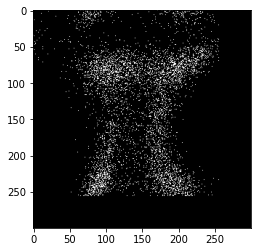

In [5]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define hyperparameters
input_dim = 5 # XYRGB values
hidden_dim = 256
latent_dim = 16
num_layers = 2
num_heads = 4
dropout = 0.1

batch_size = 128
learning_rate = 3e-4
num_epochs = 150

# Load the dataset
dataset = ColoredPiDataset('sparse_pi_colored.jpg', 'pi_xs.npy', 'pi_ys.npy')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, optimizer, and loss function
model = SelfAttentionGenerator(input_dim=input_dim, output_dim=input_dim, num_heads=num_heads, hidden_dim=hidden_dim, num_layers=num_layers ,batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train model
iteration = tqdm(range(num_epochs))
for epoch in iteration:
    train_loss = train(model, optimizer, criterion, dataloader, device)
    iteration.set_description('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))
    
# Generate some samples from the model
generated_image = np.zeros(dataset.image_array.shape)
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        # samples = model(torch.randn(batch_size, 5).to(device))
        samples = model(batch.to(device))
        
        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = torch.clip(samples[:, :2], 0, 1) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = torch.clip(samples[:, 2:], 0, 1) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

### Generate some samples from the model
- Finally, I performed the visualisation to see how the the distribution of model looks like by sampling the noise from gaussian distribution. I genrated the generated_image with the same shape of image_array. Also, I sample same number of points by iterating through the batchs in one epoch.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 159.90526774861158, xy std: 80.52151872693692, xy max: 299.0, xy min: 0.0
rgb mean: 143.94439717306574, rgb std: 49.59436431609711, rgb max: 255.0, rgb min: 0.0
Error: 16.698896296296297


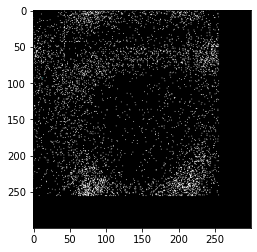

In [37]:
# Generate some samples from the model
generated_image = np.zeros(dataset.image_array.shape)
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        samples = model(torch.randn(batch_size, 5).to(device))
        # samples = model(batch.to(device))
        
        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        # samples[:, :2] = (samples[:, :2]) * 299
        samples[:, :2] = torch.clip(samples[:, :2], 0, 1) * 299

        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        # samples[:, 2:] = (samples[:, 2:]) * 255
        samples[:, 2:] = torch.clip(samples[:, 2:], 0, 1) * 255

        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)

### Generate some samples from the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


xy mean: 161.68722982365543, xy std: 59.81012078382904, xy max: 327.6067810058594, xy min: -5.121687889099121
rgb mean: 145.1180878656033, rgb std: 35.91619163715057, rgb max: 239.96041870117188, rgb min: 16.151748657226562
Error: 16.16018148148148


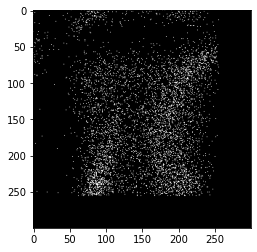

In [32]:
# Generate some samples from the model
generated_image = np.zeros(dataset.image_array.shape)
xy  = np.zeros((len(dataloader)*batch_size, 2))
rgb = np.zeros((len(dataloader)*batch_size, 3))
for sample_idx, batch in enumerate(dataloader):
    with torch.no_grad():
        samples = model(torch.rand(batch_size, 5).to(device))
        # samples = model(batch.to(device))
        
        # Denomarlizing samples
        # samples[:, :2] = (samples[:, :2] + 1) * 149.5
        samples[:, :2] = (samples[:, :2]) * 299
        
        # Denomarlizing samples
        # samples[:, 2:] = (samples[:, 2:] + 1) * 127.5
        samples[:, 2:] = (samples[:, 2:]) * 255
        
        xy[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, :2].cpu().numpy()
        rgb[sample_idx*batch_size:(sample_idx+1)*batch_size, :] = samples[:, 2:].cpu().numpy()

        samples = samples.cpu().numpy().astype(np.uint8)
        for i in range(batch_size):
            x, y, r, g, b = samples[i]
            generated_image[x, y] = [r, g, b]
            
print(f'xy mean: {np.mean(xy)}, xy std: {np.std(xy)}, xy max: {np.max(xy)}, xy min: {np.min(xy)}')
print(f'rgb mean: {np.mean(rgb)}, rgb std: {np.std(rgb)}, rgb max: {np.max(rgb)}, rgb min: {np.min(rgb)}')
print(f'Error: {np.mean(np.abs(generated_image - dataset.image_array))}')

# Save the output image
# Image.fromarray(generated_image).save('generated_pi_colored.jpg')
plt.imshow(generated_image)